In [75]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
from collections import defaultdict
import keras
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import sys
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import urllib

In [115]:
#class to create hidden layers
class HLayer:
    def __init__(self, input_shape, output_shape):
        self.output_shape = int(output_shape)
        self.input_shape = int(input_shape)
        #neurons * input_shape
        self.weights = 2 * np.random.rand(self.output_shape, self.input_shape) - 1 
        #Creating gradient_weight of size outputXinput
        self.gradient_weight = np.zeros((self.output_shape, self.input_shape))
        #Creating vector of size input
        self.output = np.zeros((self.output_shape,1))

    def sigmoid(self, WX):
        #sigmoid output
        return 1 / (1+np.exp(-WX))
    
    def sigmoid_gradient(self, WX):
        #derivative of sigmoid = sigmoid(1-sigmoid)
        return (WX * (1 - WX) * np.eye(len(WX)))
        
    def forward_pass(self, input):
        #returns sigmoid(WX)
        self.output=self.sigmoid(np.dot(self.weights, input))   
        return self.output
         
    def backward_pass(self, derivative, input, prev_shape):
        #returns gradient of output w.r.t input
        derivative = np.dot(self.sigmoid_gradient(self.output), derivative)

        return np.dot(self.weights.T, derivative)

#class to create output layers
class OLayer:        
        def __init__(self, input_shape, output_shape):
            self.output_shape = int(output_shape)
            self.input_shape = int(input_shape)
            #neurons * input_shape
            self.weights = 2 * np.random.rand(self.output_shape, self.input_shape) - 1
            #Creating gradient_weight of size outputXinput
            self.gradient_weight = np.zeros((self.output_shape, self.input_shape))
            #Creating vector of size output
            self.output = np.zeros((self.output_shape,1)) 
        
        def softmax_gradient(self, input, axis=-1):
            #derivative of softmax = (diag matrix - softmax(WX))
            return (np.eye(len(input)) * input - np.outer(input, input))
        
        def softmax(self, input, axis=-1):
        #https://stackoverflow.com/questions/34968722/how-to-implement-the-softmax-function-in-python
            e_x = np.exp(input - np.max(input))
            return e_x / e_x.sum(axis=0)
        
        def forward_pass(self, input):      
            #returns softmax(Z)
            self.output = self.softmax(np.inner(self.weights, input))
            return self.output 
            
        def backward_pass(self, input, loss):
            #returns gradient of output w.r.t input
            delta = np.dot(self.softmax_gradient(self.output), loss)
            self.gradient_weight = np.outer(delta, input)
            return np.dot(self.weights.T, delta)

#class for model creation and evaluation
class Model:
    def __init__(self):
        self.input_size = 0
        self.output_size = 0
        self.layers = []
        self.history = defaultdict(list)
    
    def create_model(self, input, output, hidden_layer):
        #Create the number of hidden and output layers
        self.input = input
        self.output = output
        prev_layer_shape = input
        #since hidden is multiple, we loop through to create using Hlayer class
        for i in hidden_layer:
            self.layers.append(HLayer(prev_layer_shape, i))
            prev_layer_shape = i
        #creating output layer from OLayer class
        self.output_lay = OLayer(prev_layer_shape, self.output)
        
    def model_fit(self, training_set_inputs, training_set_outputs, x_val, y_val, learning_rate, epochs):
        #Start with forward pass-> then backward-> compute metrics=> update parameters and run again
        for iteration in range(int(epochs)):
            for i in range(len(training_set_inputs)):
                OHLayer = self.forward_pass(training_set_inputs[i])
                cost = self.categorical_crossEntropy(OHLayer, training_set_outputs[i])
                self.backward_pass(OHLayer, training_set_outputs[i], training_set_inputs[i])
                self.equation_update(learning_rate)
            
            loss, accuracy=self.evaluate_model(training_set_inputs, training_set_outputs)
            (val_loss, val_accuracy) = self.evaluate_model(x_val, y_val)
            self.history['training_accuracy'].append(accuracy)            
            self.history['training_loss'].append(loss)
            self.history['val_accuracy'].append(val_accuracy)
            self.history['val_loss'].append(val_loss)
        return (self.history)
    
    def forward_pass(self, input):
        #Computing output for forward pass
        #hidden layers compute sigmoid(WX) and output layer compute softmax(Z)
        first_layer = input
        for i in self.layers:           
            first_layer = i.forward_pass(first_layer)
        output= self.output_lay.forward_pass(first_layer)
        return output
    
    def categorical_crossEntropy(self, OHLayer, trainingOutput):        
        logprobs = np.log(OHLayer[trainingOutput == 1])
        cost = - np.sum(logprobs) / len (OHLayer)
        return(cost)

    def categorical_derivative(self, OHLayer, trainingOutput):
        return -(trainingOutput/OHLayer)
    
    def backward_pass(self, OHLayer, trainingOutput, x_train):
        #computing derivatives for v and w's
        derivative = self.categorical_derivative(OHLayer, trainingOutput)
        prev_output = self.layers[-1].output
        delta = self.output_lay.backward_pass(prev_output, derivative)
        next_layer_weight = self.output_lay.weights
        for layer_no in range(len(self.layers)-1,0,-1):
            prev_output = self.layers[layer_no-1].output
            delta =  self.layers[layer_no].backward_pass(delta, prev_output, next_layer_weight)
            next_layer_weight = self.layers[layer_no].weights
        delta =  self.layers[0].backward_pass(delta, x_train, next_layer_weight)
    
    def equation_update(self, learning_rate):
        #For each layer (hidden and output)
        for layer in self.layers:
            layer.weights = layer.weights - (float(learning_rate) * layer.gradient_weight)
        #weights = weights - learning rate * gradient
        self.output_lay.weights = self.output_lay.weights - (float(learning_rate) * self.output_lay.gradient_weight)

    def evaluate_model(self, x, y):
        y_pred = np.zeros(y.shape)
        loss = 0
        for i in range(len(y)):
            y_pred[i] = self.forward_pass(x[i])
            loss = loss + self.categorical_crossEntropy(y_pred[i], y[i])
        loss = loss / len(y)
        accuracy = np.round(np.float(sum(np.argmax(y, axis = -1) == np.argmax(y_pred, axis = -1)))/len(y_pred) * 100, 2)
        return (loss, accuracy)

class plot:
    def plot_graph(history, epc) :
        #Accuracy
        acc=history['training_accuracy']
        val_acc=history['val_accuracy']
        pyplot.plot(acc)
        pyplot.plot(val_acc)
        pyplot.title('Accuracy')
        pyplot.ylabel('Acc')
        pyplot.xlabel('epoch')
        pyplot.legend(['train', 'validation'], loc='lower right')
        pyplot.show()

        #Losses
        loss=history['training_loss']
        val_loss=history['val_loss']
        pyplot.plot(loss)
        pyplot.plot(val_loss)
        pyplot.title('Losses')
        pyplot.ylabel('loss')
        pyplot.xlabel('epoch')
        pyplot.legend(['train', 'validation'], loc='upper right')
        pyplot.show()
        
def train_flag(x_train, y_train, x_test, y_test,epochs):
    learning_rate = .01
    model=Model()
    hidden_layer=[64,128]
    model.create_model(input = x_train.shape[-1], output = y_train.shape[-1], hidden_layer = hidden_layer)
    history = model.model_fit(x_train, y_train, x_test, y_test, learning_rate, epochs)
    print("Metrics Data:", history)
    epc=int(epochs)
    plot.plot_graph(history, epc)
    
def train_iris(x_train, y_train, x_test, y_test,epochs):
    learning_rate = .01
    model=Model()
    hidden_layer=[64,100]
    model.create_model(input = x_train.shape[-1], output = y_train.shape[-1], hidden_layer = hidden_layer)
    history = model.model_fit(x_train, y_train, x_test, y_test, learning_rate, epochs)
    print("Metrics Data:", history)
    epc=int(epochs)
    plot.plot_graph(history, epc)

In [117]:
def load_iris_data():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
    iris_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None, )
    data_path = urllib.request.urlopen(url)
    data = np.genfromtxt(data_path, dtype = 'str', missing_values='?', delimiter=',')
    y = np.array(data[:,-1])
    label_encoder = LabelEncoder()
    Trainlabels = label_encoder.fit_transform(y)
    onehot_encoder = OneHotEncoder(sparse=False)
    Trainlabels=Trainlabels.reshape(len(Trainlabels),1)
    Trainlabels=onehot_encoder.fit_transform(Trainlabels)
    Trainfeatures = data[:,:-1].astype(np.float32)
    Trainfeatures, Testfeatures, Trainlabels, Testlabels = train_test_split(Trainfeatures, Trainlabels, test_size=0.25)
    return (Trainfeatures, Trainlabels), (Testfeatures, Testlabels)
    
def load_flag_data():
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/flags/flags.data'
    data_path = urllib.request.urlopen(url)
    data = np.genfromtxt(data_path, dtype = 'str', missing_values='?', delimiter=',')
    y = np.array(data[:,-1])
    label_encoder = LabelEncoder()
    Trainlabels = label_encoder.fit_transform(y)
    onehot_encoder = OneHotEncoder(sparse=False)
    Trainlabels=Trainlabels.reshape(len(Trainlabels),1)
    Trainlabels=onehot_encoder.fit_transform(Trainlabels)
    Trainfeatures = data[:,:-1].astype(np.float32)
    Trainfeatures, Testfeatures, Trainlabels, Testlabels = train_test_split(Trainfeatures, Trainlabels, test_size=0.25)
    return (Trainfeatures, Trainlabels), (Testfeatures, Testlabels)

#### Model 1 for FLAG data
Good accuracy for 50 epochs

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Metrics Data: defaultdict(<class 'list'>, {'training_accuracy': [33.93, 54.46, 65.18, 66.07, 66.96, 66.96, 67.86, 67.86, 68.75, 70.54, 71.43, 72.32, 73.21, 73.21, 71.43, 71.43, 73.21, 75.0, 78.57, 78.57, 79.46, 82.14, 83.04, 83.93, 83.93, 85.71, 85.71, 84.82, 84.82, 87.5, 87.5, 89.29, 90.18, 90.18, 90.18, 92.86, 92.86, 92.86, 92.86, 92.86, 92.86, 94.64, 95.54, 95.54, 96.43, 96.43, 96.43, 96.43, 96.43, 96.43], 'training_loss': [0.915880350965666, 0.615678185846008, 0.5379340106427932, 0.4832111889295131, 0.4327158241683652, 0.37333226653549906, 0.30842381759015763, 0.2648205947545777, 0.257345126257313, 0.24973038556100374, 0.21922642095913503, 0.21249725088459157, 0.2022661448537388, 0.2068446582004196, 0.2428087357478743, 0.2532629565843716, 0.23125677045967558, 0.2091572331045743, 0.19108137186571153, 0.17569060137448234, 0.16204063255779214, 0.14967238175461256, 0.1383516291019586, 0.12793560416167618, 0.118319097268038, 0.10941548329779176, 0.10115150484528852, 0.09346538709746019,

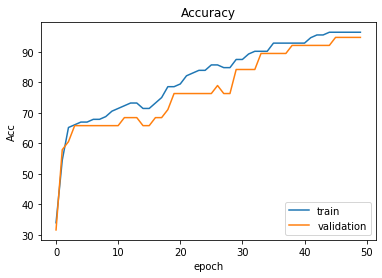

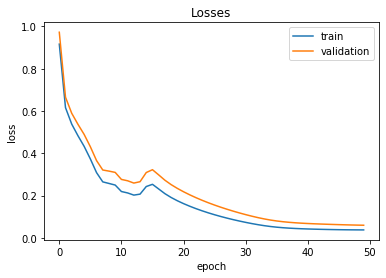

In [109]:
(x_train, y_train), (x_test, y_test) = load_flag_data()
fit_model = train_flag(x_train, y_train, x_test, y_test,50)

#### Model 2 for IRIS data
Good accuracy for 30 epochs

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Metrics Data: defaultdict(<class 'list'>, {'training_accuracy': [35.71, 66.96, 66.96, 66.96, 66.96, 66.96, 66.96, 66.96, 66.96, 66.96, 66.96, 66.96, 66.96, 66.96, 66.96, 67.86, 67.86, 67.86, 70.54, 70.54, 74.11, 82.14, 92.86, 96.43, 97.32, 97.32, 97.32, 97.32, 97.32, 97.32], 'training_loss': [0.8414811251296582, 0.578683009446755, 0.5532405080075513, 0.5364610049369424, 0.5192638021036801, 0.5009965091581386, 0.48173192307222734, 0.4615352026229755, 0.44058741028765797, 0.419304971113969, 0.3982121040468689, 0.3775091361638668, 0.3569731129181979, 0.3367280853890838, 0.31691473121678165, 0.29687385065671307, 0.27830719277959604, 0.2613247750831428, 0.24487463324534273, 0.22683445467620275, 0.19078054537983574, 0.11394503644490171, 0.06264050087908275, 0.04985905215882403, 0.04663728521815146, 0.04512800668461271, 0.044052289388689235, 0.04315628491636926, 0.04236755988955143, 0.04165702272175391], 'val_accuracy': [26.32, 63.16, 65.79, 65.79, 65.79, 65.79, 65.79, 65.79, 65.79, 65.79, 65

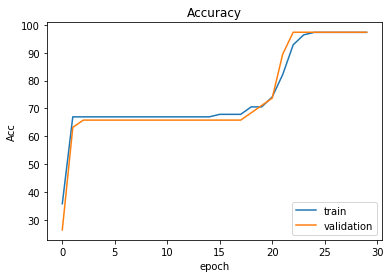

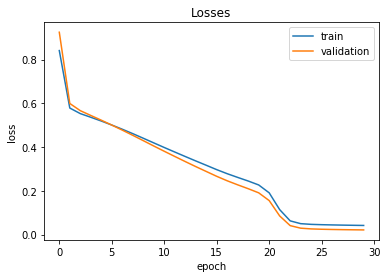

In [120]:
(x_train, y_train), (x_test, y_test) = load_iris_data()
fit_model = train_flag(x_train, y_train, x_test, y_test,30)

### References:
1.	https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
2.	https://annisap.medium.com/build-your-first-neural-network-in-python-c80c1afa464
3.	https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795
4.	https://medium.com/@a.mirzaei69/implement-a-neural-network-from-scratch-with-python-numpy-backpropagation-e82b70caa9bb
5.	https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
6.  https://stackoverflow.com/questions/34968722/how-to-implement-the-softmax-function-in-python
7.  https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
